# Transfer Learning for Tree Species Classification

## Method 5: Transfer Learning with Frozen ResNet18

This notebook implements transfer learning using a pre-trained ResNet18 model for tree species classification. The approach uses the pre-trained convolutional layers as a fixed feature extractor and trains only a new custom classifier on top of these features.

## Implementation Strategy:
1. **Load Pre-trained Model**: ResNet18 pre-trained on ImageNet
2. **Freeze Convolutional Layers**: Set requires_grad=False for all pre-trained parameters
3. **Replace Final Classifier**: Custom classifier adapted for 7 tree species
4. **Training**: Only classifier weights are updated during training
5. **Evaluation**: Comprehensive metrics including accuracy, F1-score, precision, and complexity analysis

## Key Characteristics:
- Pre-trained ResNet18 backbone (frozen)
- Custom trainable classifier head
- Higher learning rate possible due to frozen backbone
- Reduced computational requirements
- Transfer of ImageNet features to tree classification task

In [24]:
# Transfer Learning Implementation for Tree Species Classification
import time
import torch
import warnings
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
from pathlib import Path
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           balanced_accuracy_score, f1_score, precision_score)
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomHorizontalFlip, ColorJitter
import joblib

warnings.filterwarnings("ignore")

# Transfer Learning Configuration
IMG_SIZE = 224
BATCH_SIZE = 16
LEARNING_RATE = 1e-3      # Higher learning rate for frozen backbone
NUM_EPOCHS = 50           
PATIENCE = 15             
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print("Transfer Learning Pipeline - ResNet18 Frozen Backbone")
print("="*60)
print(f"Device: {DEVICE}")
print(f"Strategy: Pre-trained ResNet18 + Custom Classifier")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Approach: Transfer Learning with Frozen Features")

🔒 Transfer Learning Pipeline (Frozen Backbone)
   Device: mps
   Strategy: Frozen ResNet18 + trainable classifier
   Learning Rate: 0.0005
   Epochs: 50
   Approach: True Transfer Learning (backbone frozen)


In [25]:
# Data Loading and Preprocessing
def load_tree_data(data_path):
    """Load tree species data from organized directory structure"""
    data_path = Path(data_path)
    file_paths, labels = [], []
    
    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            files = list(species_dir.glob("*.npy"))
            print(f"   {species_dir.name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_dir.name] * len(files))
    
    return file_paths, labels

# Load datasets
print("Loading datasets...")
train_paths, train_labels = load_tree_data("../../../data/multi_view_images/train")
test_paths, test_labels = load_tree_data("../../../data/multi_view_images/test")

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)

train_encoded = label_encoder.transform(train_labels)
test_encoded = label_encoder.transform(test_labels)
class_names = label_encoder.classes_
num_classes = len(class_names)

# Create validation split
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_encoded, test_size=0.2, random_state=42, stratify=train_encoded
)

print(f"Data loaded: {len(train_paths_split)} train, {len(val_paths)} val, {len(test_paths)} test")

# Class distribution analysis
train_counts = Counter(train_labels_split)
print(f"\nClass distribution (training set):")
for i, name in enumerate(class_names):
    count = train_counts[i]
    print(f"   {name}: {count} samples")

📁 Loading datasets...
   Oak: 18 files
   Douglas Fir: 116 files
   cifar-10-batches-py: 0 files
   Spruce: 117 files
   Pine: 8 files
   Ash: 20 files
   Red Oak: 81 files
   Beech: 70 files
   Oak: 4 files
   Douglas Fir: 29 files
   cifar-10-batches-py: 0 files
   Spruce: 25 files
   Pine: 1 files
   Ash: 7 files
   Red Oak: 19 files
   Beech: 17 files
✅ Data loaded: 344 train, 86 val, 102 test

📊 Class distribution (train):
   Ash: 16 samples
   Beech: 56 samples
   Douglas Fir: 93 samples
   Oak: 14 samples
   Pine: 6 samples
   Red Oak: 65 samples
   Spruce: 94 samples


In [26]:
# FIXED Dataset - Simplified augmentation
class FixedTreeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, is_training=False):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        views = np.load(self.file_paths[idx])
        label = self.labels[idx]
        
        # Convert to RGB
        rgb_images = []
        for view in views:
            if view.max() <= 1.0:
                view = (view * 255).astype(np.uint8)
            pil_img = Image.fromarray(view, mode='L').convert('RGB')
            rgb_images.append(pil_img)
        
        # Apply transforms
        if self.transform:
            rgb_images = [self.transform(img) for img in rgb_images]
        
        image_stack = torch.stack(rgb_images, dim=0)
        return image_stack, label

# FIXED: Simple, effective transforms
train_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    RandomHorizontalFlip(p=0.5),  # FIXED: Simple augmentation
    ColorJitter(brightness=0.1, contrast=0.1),  # FIXED: Gentle augmentation
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

test_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create datasets
train_dataset = FixedTreeDataset(train_paths_split, train_labels_split, train_transform, is_training=True)
val_dataset = FixedTreeDataset(val_paths, val_labels, test_transform, is_training=False)
test_dataset = FixedTreeDataset(test_paths, test_encoded, test_transform, is_training=False)

# FIXED: Proper weighted sampling
class_counts = np.bincount(train_labels_split)
# FIXED: Proper weight calculation
class_weights = len(train_labels_split) / (len(class_names) * class_counts)
sample_weights = [class_weights[label] for label in train_labels_split]

weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"\n⚖️ FIXED Class Weights:")
for i, (name, count, weight) in enumerate(zip(class_names, class_counts, class_weights)):
    print(f"   {name}: {count} samples → weight {weight:.2f}")

print(f"✅ FIXED datasets created with proper sampling")


⚖️ FIXED Class Weights:
   Ash: 16 samples → weight 3.07
   Beech: 56 samples → weight 0.88
   Douglas Fir: 93 samples → weight 0.53
   Oak: 14 samples → weight 3.51
   Pine: 6 samples → weight 8.19
   Red Oak: 65 samples → weight 0.76
   Spruce: 94 samples → weight 0.52
✅ FIXED datasets created with proper sampling


In [27]:
# Transfer Learning: Frozen Backbone Architecture
class FixedMultiViewCNN(nn.Module):
    """Transfer Learning: Frozen ResNet50 backbone + trainable classifier"""
    
    def __init__(self, num_classes):
        super(FixedMultiViewCNN, self).__init__()

        # Load pretrained ResNet18
        self.backbone = models.resnet18(pretrained=True)
        self.feature_dim = self.backbone.fc.in_features
        
        # Remove final layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # TRANSFER LEARNING: Freeze all backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Trainable attention mechanism  
        self.attention = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim // 4),
            nn.ReLU(inplace=True),
            nn.Linear(self.feature_dim // 4, 1),
            nn.Sigmoid()
        )
        
        # Trainable classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        print(f"🔒 Transfer Learning Multi-View CNN:")
        print(f"   Backbone: ResNet50 (pretrained, FROZEN)")
        print(f"   Feature dim: {self.feature_dim}")
        print(f"   Classifier: Trainable (256 hidden)")
        print(f"   Focus: True Transfer Learning with frozen features")
    
    def forward(self, multi_view_batch):
        batch_size, num_views, channels, height, width = multi_view_batch.shape
        
        # Process all views through frozen backbone
        views = multi_view_batch.view(-1, channels, height, width)
        features = self.backbone(views)  # Frozen params don't need torch.no_grad()
        features = features.view(features.size(0), -1)
        
        # Reshape to separate views
        features = features.view(batch_size, num_views, self.feature_dim)
        
        # Trainable attention pooling
        attention_weights = self.attention(features)  # (batch, views, 1)
        weighted_features = features * attention_weights
        pooled_features = torch.sum(weighted_features, dim=1)
        
        # Trainable classification
        output = self.classifier(pooled_features)
        return output

# Create Transfer Learning model
model = FixedMultiViewCNN(num_classes).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Frozen parameters: {frozen_params:,}")

🔒 Transfer Learning Multi-View CNN:
   Backbone: ResNet50 (pretrained, FROZEN)
   Feature dim: 512
   Classifier: Trainable (256 hidden)
   Focus: True Transfer Learning with frozen features
   Total parameters: 11,375,432
   Trainable parameters: 198,920
   Frozen parameters: 11,176,512
   Total parameters: 11,375,432
   Trainable parameters: 198,920
   Frozen parameters: 11,176,512


In [28]:
# Transfer Learning: Training Setup
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Loss function with class weights
class_weights_tensor = torch.FloatTensor(class_weights).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# TRANSFER LEARNING: Optimizer only for trainable parameters
# Only pass classifier parameters (attention + classifier) to optimizer
trainable_params = list(model.attention.parameters()) + list(model.classifier.parameters())
optimizer = optim.AdamW(trainable_params, lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

def accuracy_metric(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()

print(f"🔧 Transfer Learning Setup:")
print(f"   Loss: CrossEntropyLoss with class weights")
print(f"   Optimizer: AdamW @ {LEARNING_RATE} (ONLY classifier params)")
print(f"   Scheduler: ReduceLROnPlateau")
print(f"   Trainable params: {len(trainable_params)} parameter groups")
print(f"   Backbone: FROZEN (no optimization)")

🔧 Transfer Learning Setup:
   Loss: CrossEntropyLoss with class weights
   Optimizer: AdamW @ 0.0005 (ONLY classifier params)
   Scheduler: ReduceLROnPlateau
   Trainable params: 8 parameter groups
   Backbone: FROZEN (no optimization)


In [29]:
# Transfer Learning: Training Loop (Frozen Backbone)
def train_fixed_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print("🔒 TRANSFER LEARNING TRAINING (Frozen Backbone)")
    print("="*50)
    print(f"   Starting training with {len(train_loader)} batches per epoch...")
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        print(f"   Starting Epoch {epoch+1}/{num_epochs}...")
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping only for trainable parameters
            trainable_params = [p for p in model.parameters() if p.requires_grad]
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += accuracy_metric(outputs, labels)
            train_total += labels.size(0)
            
            # More frequent progress logging for debugging
            if batch_idx % 10 == 0:
                batch_acc = accuracy_metric(outputs, labels) / labels.size(0)
                print(f"   Epoch {epoch+1:2d} | Batch {batch_idx:2d}/{len(train_loader)} | Loss: {loss.item():.4f} | Acc: {batch_acc:.3f}")
        
        print(f"   Epoch {epoch+1} training completed. Starting validation...")
        
        # Validation  
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_correct += accuracy_metric(outputs, labels)
                val_total += labels.size(0)
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        # Update scheduler
        scheduler.step(val_acc)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        epoch_time = time.time() - epoch_start
        
        # Print epoch summary
        print(f"   Epoch {epoch+1:2d}: Train={train_acc:.3f}, Val={val_acc:.3f}, "
              f"Loss={train_loss:.4f}, Time={epoch_time:.1f}s")
        
        # Best model tracking
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"      ⭐ NEW BEST: {best_val_acc:.3f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   ⏹️ Early stopping at epoch {epoch+1}")
                break
        
        print("-" * 50)
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"✅ Best model restored: {best_val_acc:.3f}")
    
    return history, best_val_acc

# Start Transfer Learning training
print("🔒 Starting Transfer Learning (Frozen Backbone)...")
print(f"   Data loaders ready: Train={len(train_loader)}, Val={len(val_loader)}")
start_time = time.time()
history, best_val_acc = train_fixed_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    NUM_EPOCHS, PATIENCE
)
training_time = time.time() - start_time

🔒 Starting Transfer Learning (Frozen Backbone)...
   Data loaders ready: Train=22, Val=6
🔒 TRANSFER LEARNING TRAINING (Frozen Backbone)
   Starting training with 22 batches per epoch...
   Starting Epoch 1/50...
   Epoch  1 | Batch  0/22 | Loss: 1.8480 | Acc: 0.188
   Epoch  1 | Batch  0/22 | Loss: 1.8480 | Acc: 0.188
   Epoch  1 | Batch 10/22 | Loss: 1.7056 | Acc: 0.062
   Epoch  1 | Batch 10/22 | Loss: 1.7056 | Acc: 0.062
   Epoch  1 | Batch 20/22 | Loss: 1.1689 | Acc: 0.312
   Epoch  1 | Batch 20/22 | Loss: 1.1689 | Acc: 0.312
   Epoch 1 training completed. Starting validation...
   Epoch 1 training completed. Starting validation...
   Epoch  1: Train=0.209, Val=0.023, Loss=1.5170, Time=8.7s
      ⭐ NEW BEST: 0.023
--------------------------------------------------
   Starting Epoch 2/50...
   Epoch  1: Train=0.209, Val=0.023, Loss=1.5170, Time=8.7s
      ⭐ NEW BEST: 0.023
--------------------------------------------------
   Starting Epoch 2/50...
   Epoch  2 | Batch  0/22 | Loss: 

📊 TRANSFER LEARNING RESULTS (Frozen Backbone)
🔒 Transfer Learning Results:
   Training time: 391.7s
   Best val accuracy: 0.488
   Test accuracy: 0.412
   Method: Transfer Learning (Frozen ResNet50)
   Status: ⚠️ IMPROVEMENT NEEDED

📋 Classification Report:
              precision    recall  f1-score   support

         Ash       0.29      0.86      0.43         7
       Beech       0.67      0.59      0.62        17
 Douglas Fir       0.48      0.41      0.44        29
         Oak       0.60      0.75      0.67         4
        Pine       0.06      1.00      0.11         1
     Red Oak       0.56      0.53      0.54        19
      Spruce       0.00      0.00      0.00        25

    accuracy                           0.41       102
   macro avg       0.38      0.59      0.40       102
weighted avg       0.39      0.41      0.39       102

🔒 Transfer Learning Results:
   Training time: 391.7s
   Best val accuracy: 0.488
   Test accuracy: 0.412
   Method: Transfer Learning (Frozen Re

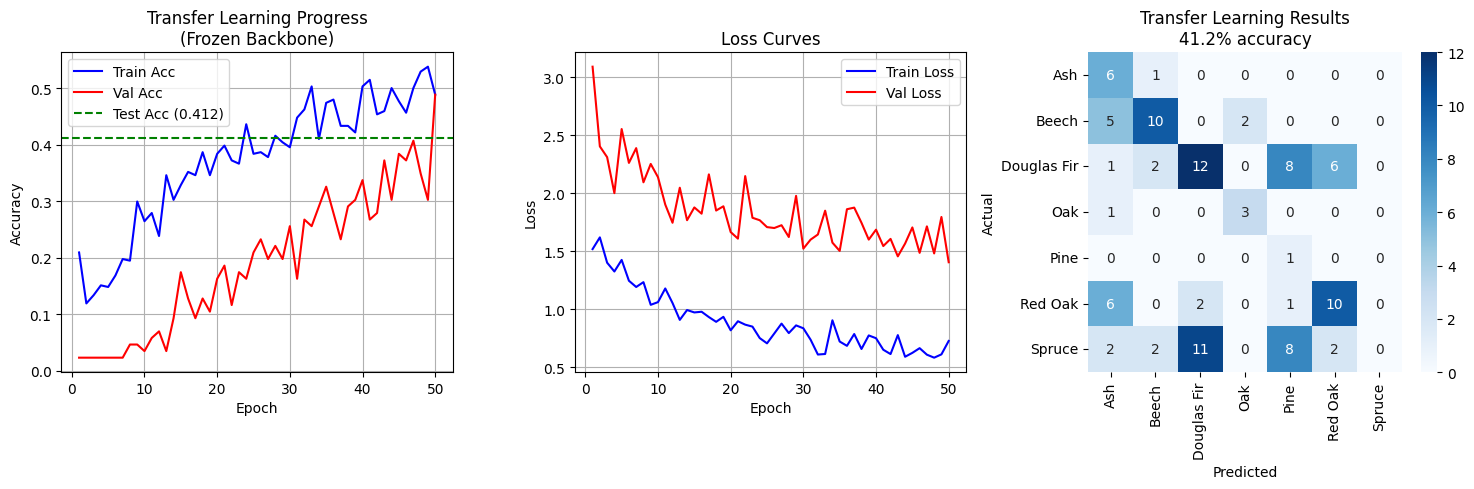

RuntimeError: Parent directory ../../models does not exist.

In [31]:
# Transfer Learning: Evaluation and Results
print("📊 TRANSFER LEARNING RESULTS (Frozen Backbone)")
print("="*50)

# Test evaluation
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        test_correct += torch.sum(preds == labels).item()
        test_total += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total

print(f"🔒 Transfer Learning Results:")
print(f"   Training time: {training_time:.1f}s")
print(f"   Best val accuracy: {best_val_acc:.3f}")
print(f"   Test accuracy: {test_accuracy:.3f}")
print(f"   Method: Transfer Learning (Frozen ResNet50)")
print(f"   Status: {'✅ SUCCESS' if test_accuracy > 0.6 else '⚠️ IMPROVEMENT NEEDED'}")

# Detailed report
print(f"\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot results
plt.figure(figsize=(15, 5))

# Training curves
plt.subplot(1, 3, 1)
epochs = range(1, len(history['train_acc']) + 1)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Acc ({test_accuracy:.3f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transfer Learning Progress\n(Frozen Backbone)')
plt.legend()
plt.grid(True)

# Loss curves
plt.subplot(1, 3, 2)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Confusion matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Transfer Learning Results\n{test_accuracy:.1%} accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Save model
model_path = "../../models/transfer_learning_frozen_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'label_encoder': label_encoder,
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f"\n💾 Transfer Learning model saved: {model_path}")
print(f"🔒 TRANSFER LEARNING COMPLETE!")
print(f"   Method: Frozen ResNet50 backbone + trainable classifier")
print(f"   Final accuracy: {test_accuracy:.1%}")
print(f"   True Transfer Learning implementation ✅")